In [1]:
import pandas as pd

splits = {'validation': 'data/validation-00000-of-00001.parquet',}
df = pd.read_parquet("hf://datasets/tau/commonsense_qa/" + splits["validation"])
df.head(5)

,id,question,question_concept,choices,answerKey
0,1afa02df02c908a558b4036e80242fac,A revolving door is convenient for two directi...,revolving door,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",A
1,a7ab086045575bb497933726e4e6ad28,What do people aim to do at work?,people,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",A
2,b8c0a4703079cf661d7261a60a1bcbff,Where would you find magazines along side many...,magazines,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",B
3,e68fb2448fd74e402aae9982aa76e527,Where are you likely to find a hamburger?,hamburger,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",A
4,2435de612dd69f2012b9e40d6af4ce38,James was looking for a good place to buy farm...,farmland,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",A


In [2]:
df.shape

(1221, 5)

In [3]:
df['choices_dict'] = df['choices'].apply(lambda x: dict(zip(x['label'], x['text'])))
df.head()

,id,question,question_concept,choices,answerKey,choices_dict
0,1afa02df02c908a558b4036e80242fac,A revolving door is convenient for two directi...,revolving door,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",A,"{'A': 'bank', 'B': 'library', 'C': 'department..."
1,a7ab086045575bb497933726e4e6ad28,What do people aim to do at work?,people,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",A,"{'A': 'complete job', 'B': 'learn from each ot..."
2,b8c0a4703079cf661d7261a60a1bcbff,Where would you find magazines along side many...,magazines,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",B,"{'A': 'doctor', 'B': 'bookstore', 'C': 'market..."
3,e68fb2448fd74e402aae9982aa76e527,Where are you likely to find a hamburger?,hamburger,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",A,"{'A': 'fast food restaurant', 'B': 'pizza', 'C..."
4,2435de612dd69f2012b9e40d6af4ce38,James was looking for a good place to buy farm...,farmland,"{'label': ['A', 'B', 'C', 'D', 'E'], 'text': [...",A,"{'A': 'midwest', 'B': 'countryside', 'C': 'est..."


In [4]:
item=df.iloc[0]
print(item.question)
print(item.choices)
print(item.choices_dict)
print(item.answerKey)

A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
{'label': array(['A', 'B', 'C', 'D', 'E'], dtype=object), 'text': array(['bank', 'library', 'department store', 'mall', 'new york'],
      dtype=object)}
{'A': 'bank', 'B': 'library', 'C': 'department store', 'D': 'mall', 'E': 'new york'}
A


In [5]:
from typing import Optional, List, Dict, Tuple
from pydantic import BaseModel, Field

class Entity(BaseModel):
    id: str
    question: str
    question_concept: str
    choices: Dict[str,List[str]]
    answerKey: str
    choices_dict: Dict[str, str]
    

class ReasoningPath(BaseModel):
    question: str
    choices_dict: Dict[str,str]
    reason: str
    answer: str
    ground_truth: str
    temperature: float
    tokens: int
    score: float

entities = [Entity.model_validate(row) for row in df.to_dict(orient='records')]
print(len(entities))
print(entities[0])

1221
id='1afa02df02c908a558b4036e80242fac' question='A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?' question_concept='revolving door' choices={'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['bank', 'library', 'department store', 'mall', 'new york']} answerKey='A' choices_dict={'A': 'bank', 'B': 'library', 'C': 'department store', 'D': 'mall', 'E': 'new york'}


In [6]:
import re
from sot.sot import SoT
from typing import Tuple, Union
from doraemon.logger_util import get_logger
from doraemon.inference_factory import InferenceFactory

logger=get_logger(name=__name__, logfile="MATH_dataset_builder.log")

def get_answer(raw_answer: str)-> str:
    answer=re.search(r"\\boxed\{(.*?)\}", raw_answer)
    if answer:
        return answer.group(1)
    return None
    

def process_entity(args)-> Optional[Tuple[ReasoningPath, int]]:
    """
    """
    et,paradigm,temperature=args

    try:
        prompt=SoT.get_initialized_prompt(paradigm=paradigm, question=f"Question:{et.question}\nChoices:{str(et.choices_dict)}")

        r_s, tokens=InferenceFactory.inference(logger=logger, messages=prompt, temperature=temperature)
        logger.info(f"The reasonining path: {r_s}")
        result=ReasoningPath(
            question=str(et.question), 
            choices_dict=et.choices_dict,
            reason=str(r_s), 
            answer=get_answer(r_s),
            ground_truth=str(et.answerKey),
            temperature=float(temperature), 
            tokens=int(tokens), 
            score=0.0)
        return result, tokens
    except Exception as e:
        logger.error(f"Error processing quetion {et.question} at temperature {temperature} with exception {e}")
        return None


paradigm = SoT.classify_question(entities[0].question)
logger.info(paradigm)
assert "conceptual_chaining"==str(paradigm)

2025-06-06 06:42:55.465299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749192175.695126      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749192175.768094      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

2025-06-06 06:43:11,867 INFO conceptual_chaining


In [7]:
temperatures = [i * 0.25 for i in range(9)]  # [0.0, 0.25, 0.5, ... ,2.0]

tasks=[]
for et in entities:
    for tp in temperatures:
        tasks.append((et,paradigm,tp))
tasks[0]

(Entity(id='1afa02df02c908a558b4036e80242fac', question='A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?', question_concept='revolving door', choices={'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['bank', 'library', 'department store', 'mall', 'new york']}, answerKey='A', choices_dict={'A': 'bank', 'B': 'library', 'C': 'department store', 'D': 'mall', 'E': 'new york'}),
 'conceptual_chaining',
 0.0)

In [8]:
from tqdm import tqdm
import concurrent.futures

with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
    results=list(tqdm(executor.map(process_entity, tasks), total=len(tasks)))

  0%|          | 0/10989 [00:00<?, ?it/s]2025-06-06 06:43:14,503 INFO The reasonining path: <think>
Let’s think through this step by step
#revolving_door → #security_measure → #bank
</think>
\boxed{A}
  0%|          | 1/10989 [00:02<6:11:41,  2.03s/it]2025-06-06 06:43:15,118 INFO The reasonining path: <think>
Let’s think through this step by step
#revolving_door → #security_measure → #bank
</think>
\boxed{A}
  0%|          | 2/10989 [00:02<3:38:49,  1.20s/it]2025-06-06 06:43:17,000 INFO The reasonining path: <think>
Let’s think through this step by step
#revolving_door → #security_measure → #bank
</think>
\boxed{A}
  0%|          | 3/10989 [00:04<4:36:16,  1.51s/it]2025-06-06 06:43:17,644 INFO The reasonining path: <think>
Let’s think through this step by step
#revolving_door → #security_measure → #bank
</think>
\boxed{A}
  0%|          | 4/10989 [00:05<3:33:40,  1.17s/it]2025-06-06 06:43:42,334 INFO The reasonining path: <think>
Let’s think through this step by step
#revolving_door → 

In [9]:
from typing import List

multipleReasonPaths: List[ReasoningPath]=[]

for rs_token in results:
    if rs_token is not None:
        reason_path,_=rs_token
        multipleReasonPaths.append(reason_path)

len(multipleReasonPaths)

10744

In [10]:
logger.info(multipleReasonPaths[0])
logger.info(multipleReasonPaths[0].answer)

2025-06-06 09:37:35,575 INFO question='A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?' choices_dict={'A': 'bank', 'B': 'library', 'C': 'department store', 'D': 'mall', 'E': 'new york'} reason='<think>\nLet’s think through this step by step\n#revolving_door → #security_measure → #bank\n</think>\n\\boxed{A}' answer='A' ground_truth='A' temperature=0.0 tokens=32 score=0.0
2025-06-06 09:37:35,577 INFO A


In [11]:
import pickle
from datetime import datetime
from datasets import Dataset

def convert_rp_to_ds(multipleReasonPaths: List[ReasoningPath]) -> Dataset:
    data_dicts = [rp.model_dump() for rp in multipleReasonPaths]
    # Create a Dataset from the list of dictionaries
    return Dataset.from_list(data_dicts)

def to_pkl(ds: Dataset, filename: str):
    with open(filename, 'wb') as f:
        pickle.dump(ds, f)


ds=convert_rp_to_ds(multipleReasonPaths)

to_pkl(ds, filename=f"commonsense-qa-reasoning-path.pkl")

In [12]:
df = ds.to_pandas()
df.head(10)

,question,choices_dict,reason,answer,ground_truth,temperature,tokens,score
0,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,0.00,32,0.0
1,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,0.25,32,0.0
2,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,0.50,32,0.0
3,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,0.75,32,0.0
4,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,1.00,32,0.0
5,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,1.25,32,0.0
6,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,1.50,32,0.0
7,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,1.75,32,0.0
8,A revolving door is convenient for two directi...,"{'A': 'bank', 'B': 'library', 'C': 'department...",<think>\nLet’s think through this step by step...,A,A,2.00,32,0.0
9,What do people aim to do at work?,"{'A': 'complete job', 'B': 'learn from each ot...",<think>\nLet’s think through this step by step...,A,A,0.00,27,0.0


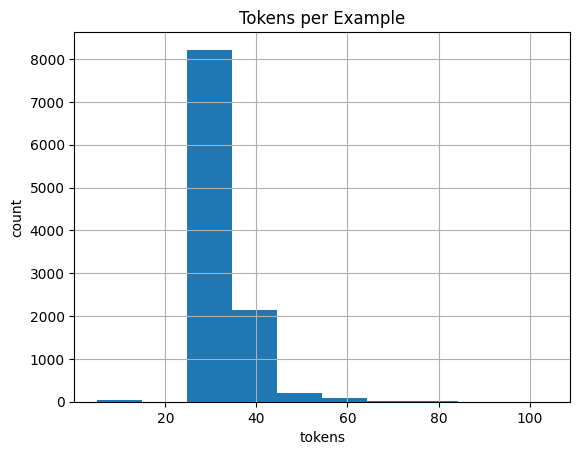

In [13]:
import matplotlib.pyplot as plt

# Tokens distribution
plt.figure()
df['tokens'].hist()
plt.title("Tokens per Example")
plt.xlabel("tokens")
plt.ylabel("count")
plt.show()